In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform, LinearFilterBank, DyadicFilterBank
import matplotlib.pyplot as plt
from invertiblewavelets import *
import time
from magprime.algorithms import UBSS, MSSA

#### Load Example Data from Swarm A Spacecraft Magnetoemter

In [2]:
data = np.load("data.npy")
data = np.pad(data, 1, mode = 'constant', constant_values = 0)
# Adding some noise
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array

B1 = data + 0 *np.sin(2 * np.pi * 6.4 * t) + 50 * signal.square(2 * np.pi * .5* t)
B2 = data + 0 *np.sin(2 * np.pi * 6.4 * t) + 10* signal.square(2 * np.pi * .5 * t)
B3 = data + -0 *np.sin(2 * np.pi * 6.4 * t) + 100* signal.square(2 * np.pi * .5 * t)
B = np.vstack((B1,B2, B3))

In [3]:
B.shape

(3, 5002)

#### Create Transform Object and Analysis Filters

In [4]:
fb = DyadicFilterBank(wavelet=Morlet() , fs=sample_rate, N=4999, real=True, dj = 1/8, s_max=4)
transform = Transform(
    data=B[0],
    fs = sample_rate,
    filterbank=fb,
)

(54, 10001) (54, 10001)


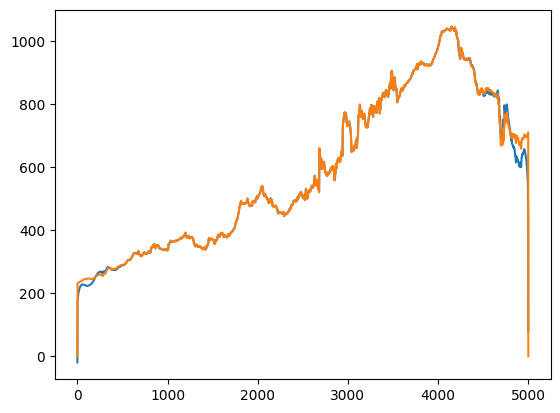

In [5]:
plt.plot(transform.inverse(transform.forward(data, mode='same')))
plt.plot(data)
plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm.notebook  import tqdm
%matplotlib inline


# -------------------------------------------------------------------
# worker: 1 filter-length ➜ RMSE
# -------------------------------------------------------------------
def rmse_for_Lh(Lh, sample_rate, data):
    fb = DyadicFilterBank(
        wavelet=Morlet(),
        fs=sample_rate,
        N=Lh,
        real=True,
        dj=1/8,
        s_max=4,
    )
    tr    = Transform(data=data, fs=sample_rate, filterbank=fb)
    recon = tr.inverse(tr.forward(data, mode='same'))

    margin = Lh
    err    = recon[margin:-margin] - data[margin:-margin]
    return np.sqrt(np.mean(err**2))


# -------------------------------------------------------------------
# main: parallel sweep with a *responsive* bar
# -------------------------------------------------------------------
# --- analysis target ---------------------------------------------
low, high = 1_000, 2000          # inclusive start, exclusive stop
rng       = np.random.default_rng(42)   # seed for reproducibility

# keep stepping by 1‒10 until we’d exceed `high`
steps = rng.integers(1, 11, size=high-low)     # overshoot then trim
Lhs   = np.cumsum(np.insert(steps, 0, low))    # start at 1000
Lhs   = Lhs[Lhs < high]
rmses  = []


# --- sweep (single process, live plot) ---------------------------
for Lh in tqdm(Lhs, desc="Computing RMSE"):
    rmse = rmse_for_Lh(Lh, sample_rate=sample_rate, data=data)
    rmses.append(rmse)


Computing RMSE:   0%|          | 0/179 [00:00<?, ?it/s]

(54, 6001) (54, 6001)
(54, 6003) (54, 6003)
(54, 6011) (54, 6011)
(54, 6017) (54, 6017)
(54, 6023) (54, 6023)
(54, 6027) (54, 6027)
(54, 6037) (54, 6037)
(54, 6037) (54, 6037)
(54, 6045) (54, 6045)
(54, 6047) (54, 6047)
(54, 6049) (54, 6049)
(54, 6055) (54, 6055)
(54, 6065) (54, 6065)
(54, 6073) (54, 6073)
(54, 6081) (54, 6081)
(54, 6089) (54, 6089)
(54, 6097) (54, 6097)
(54, 6103) (54, 6103)
(54, 6105) (54, 6105)
(54, 6113) (54, 6113)
(54, 6119) (54, 6119)
(54, 6125) (54, 6125)
(54, 6129) (54, 6129)
(54, 6131) (54, 6131)
(54, 6141) (54, 6141)
(54, 6149) (54, 6149)
(54, 6155) (54, 6155)
(54, 6161) (54, 6161)
(54, 6169) (54, 6169)
(54, 6175) (54, 6175)
(54, 6181) (54, 6181)
(54, 6185) (54, 6185)
(54, 6189) (54, 6189)
(54, 6189) (54, 6189)
(54, 6195) (54, 6195)
(54, 6205) (54, 6205)
(54, 6205) (54, 6205)
(54, 6215) (54, 6215)
(54, 6223) (54, 6223)
(54, 6227) (54, 6227)
(54, 6233) (54, 6233)
(54, 6235) (54, 6235)
(54, 6243) (54, 6243)
(54, 6251) (54, 6251)
(54, 6255) (54, 6255)
(54, 6257)

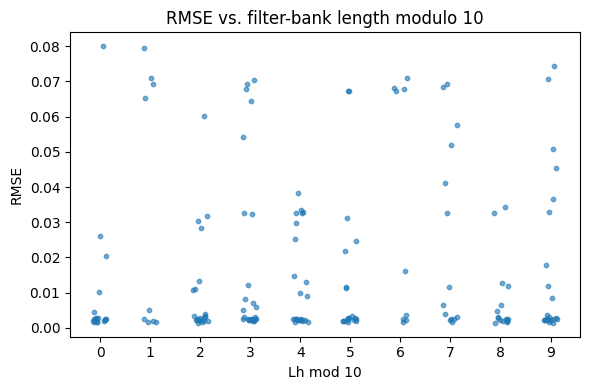

In [8]:
# --- modulo-10 values -------------------------------------------------
nan_mask = np.isnan(rmses)          # mask for NaN values
rmses = np.array(rmses)[~nan_mask]             # remove NaN values
Lhs = np.array(Lhs)[~nan_mask]                # remove corresponding Lh values
mods = np.mod(Lhs, 10)             # vector of length len(Lhs)

# ── 1) strip-plot (all points with a tiny horizontal jitter) ──────────
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(
    mods + np.random.uniform(-0.15, 0.15, size=mods.size),  # jitter
    rmses,
    s     = 10,
    alpha = 0.6,
)

ax.set_xticks(range(10))
ax.set_xlabel("Lh mod 10")
ax.set_ylabel("RMSE")
ax.set_title("RMSE vs. filter-bank length modulo 10")
plt.tight_layout()
plt.show()

#### Transform


In [6]:
#### WAICUP
start = time.time()
def WAICUP(w1, w2):
    D = w2 - w1  # shape (J, T), complex

    # 1) correlations (eqs 6–7), using conjugate inner products
    C1 = np.sum( D * np.conj(w1), axis=1 )   # shape (J,)
    C2 = np.sum( D * np.conj(w2), axis=1 )   # shape (J,)

    # 2) gain estimate K̂ per scale (eq 8)
    K_hat = C2 / C1                          # shape (J,)
    # (optionally force to real if you know K is real:)
    K_hat = K_hat

    # 3) residuals (eq 9)
    A = (w1-w2) / (K_hat[:,None]-1)  # shape (J, T), complex

    # 4) ambient‑field estimate X(s,τ) (eq 10)
    X = (K_hat[:,None]*w1 - w2) / (K_hat[:,None] - 1) 
    return X, A

w1 = transform.forward(B[0], mode='same')
w2 = transform.forward(B[1], mode='same')
w3 = transform.forward(B[2], mode='same')

X1, A1 = WAICUP(w1, w2)
X2, A2 = WAICUP(w1, w3)
X3, A3 = WAICUP(w2, w3)

abs_A1 = np.abs(X1)  # shape (J, T)
abs_A2 = np.abs(X2)  # shape (J, T)
abs_A3 = np.abs(X3)  # shape (J, T)

# Stack the absolute values along a new axis
abs_A_stack = np.stack([abs_A1, abs_A2, abs_A3], axis=0)  # shape (3, J, T)

# Find the indices of the maximum absolute A values
max_indices = np.argmin(abs_A_stack, axis=0)  # shape (J, T)

# Initialize X_result with the same shape as X1, X2, X3
X_result = np.zeros_like(X1, dtype=X1.dtype)

# Use advanced indexing to select the corresponding X values
# Create a meshgrid of indices for J and T
j_indices, t_indices = np.indices(max_indices.shape)

# Select X values based on max_indices
X_result[j_indices, t_indices] = np.where(
    max_indices == 0, X1[j_indices, t_indices],
    np.where(max_indices == 1, X2[j_indices, t_indices], X3[j_indices, t_indices])
)
X_min = np.minimum.reduce([X1, X2, X3])
result = transform.inverse(X1)
end = time.time()
print("Time taken for WAICUP: ", end - start)

Time taken for WAICUP:  0.7506721019744873


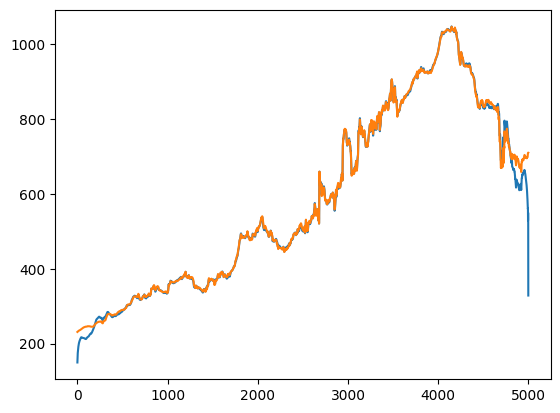

In [7]:
plt.plot(result)
plt.plot(data)
plt.show()

Raw Error:  709.5622566230248
Raw Error:  145.312621050344
Cleaned Error:  30.32648329704815


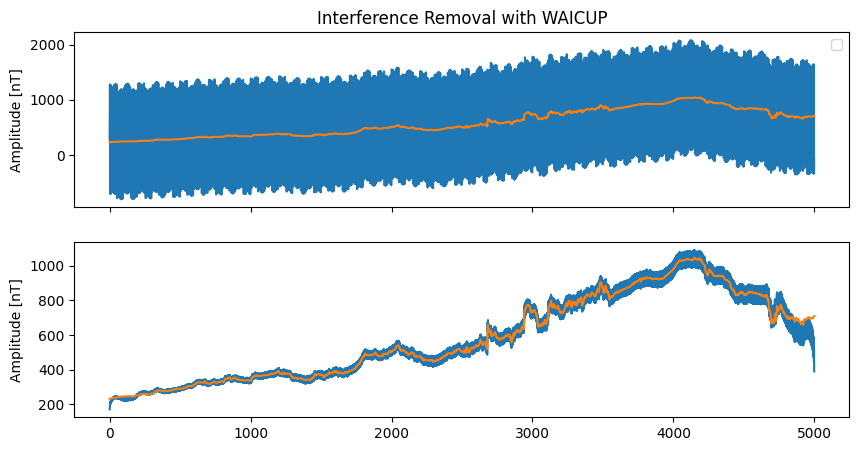

In [11]:
print("Raw Error: ", np.sqrt(((B[0,200:-200]-result[200:-200])**2).mean(axis=0)))
print("Raw Error: ", np.sqrt(((B[1,200:-200]-result[200:-200])**2).mean(axis=0)))
print("Cleaned Error: ", np.sqrt(((data[1000:-1000]-result[:5000][1000:-1000])**2).mean(axis=0)))

%matplotlib inline
fig, ax = plt.subplots(2,1, sharex=True, figsize=(10, 5))

ax[0].legend()
ax[0].plot(B[0], label='B1')
ax[0].plot(data, label='Swarm')
ax[1].plot(result, label='WAIC-UP')
ax[1].plot(data, label='Swarm')
ax[0].set_title('Interference Removal with WAICUP')
ax[0].set_ylabel('Amplitude [nT]')
ax[1].set_ylabel('Amplitude [nT]')
plt.show()

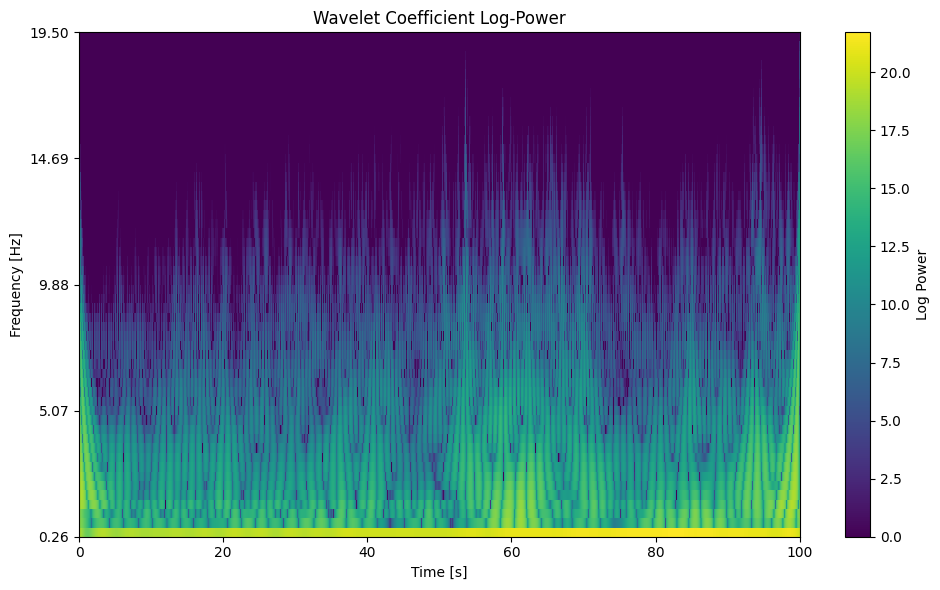

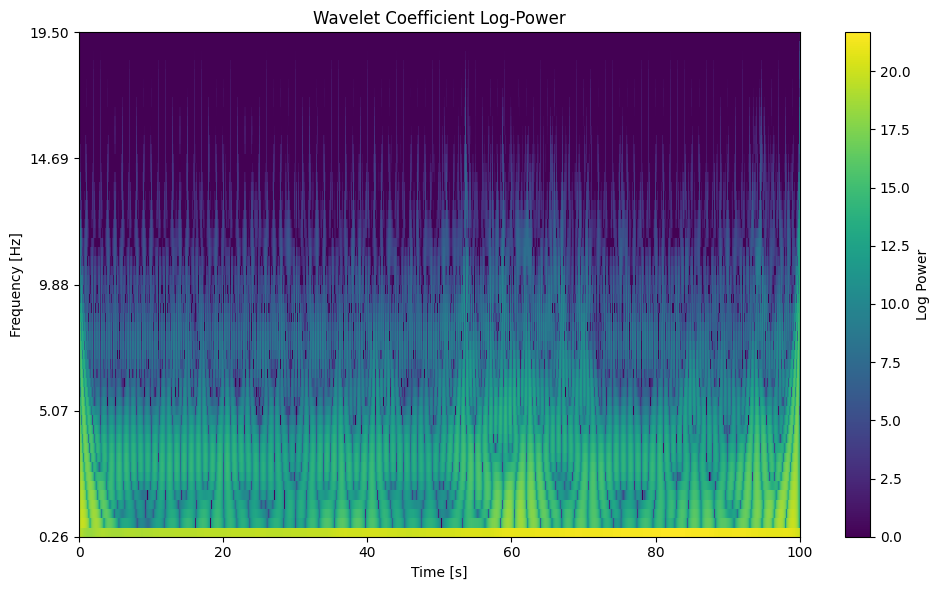

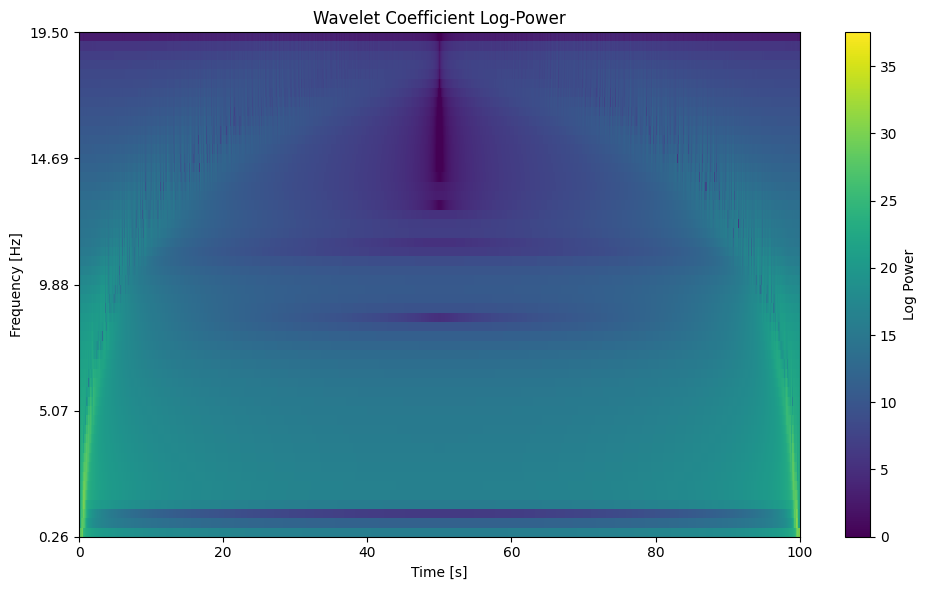

In [141]:
transform.scalogram(X_min, vmin=0, interpolation='none')
transform.scalogram(w2,vmin=0, interpolation='none')
transform.scalogram(np.fft.fft(X_min, axis=1),vmin=0, interpolation='none')
plt.show()

#### Compare to Normal WAICUP

(577.2322143336834+0j)
2.1607798061937764


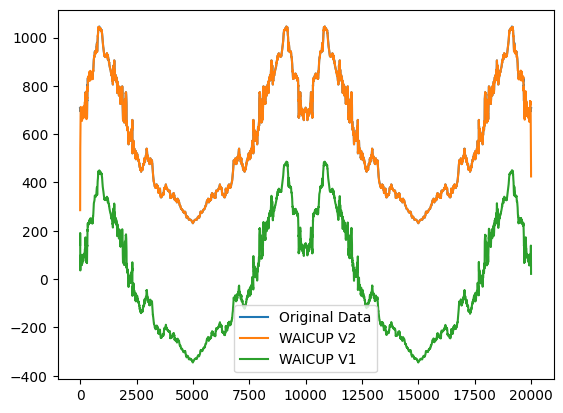

In [9]:
from magprime.algorithms import WAICUP
%matplotlib inline
WAICUP.fs = sample_rate
WAICUP.detrend= False
result_baseline = WAICUP.clean(B, triaxial=False)
print(np.sqrt(((data-result_baseline)**2).mean(axis=0)))
print(np.sqrt(((data[100:-100]-result[100:-100])**2).mean(axis=0)))
plt.plot(data, label='Original Data')
plt.plot(result, label='WAICUP V2')
plt.plot(result_baseline, label='WAICUP V1')
plt.legend()
plt.show()

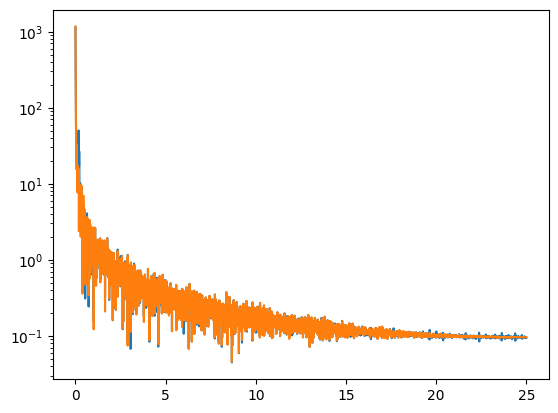

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = 5000
# sample spacing
T = 1.0 / 50
x = np.linspace(0.0, N*T, N)
y = data
yf = scipy.fftpack.fft(y)
yf2 = scipy.fftpack.fft(result)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf2[:N//2]))
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))


ax.set_yscale('log')
plt.show()


In [86]:
fig, ax = plt.subplots(2,1)
i = 0
N = w1.shape[-1]
freqs = np.fft.fftfreq(N, d=1/sample_rate)
ax[0].plot(freqs[:N//2], np.abs(transform.Wfreq[i][:N//2]))
ax[0].plot(freqs[:N//2], np.abs(transform.Wfreq[i+1][:N//2]))
ax[1].plot(freqs[:N//2], np.abs(np.fft.fft(w1, axis=1))[i][:N//2])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')